# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



## Loading data

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances


In [71]:
alldata = pd.read_excel('alldata.xlsx')
drdata = pd.read_excel('drdata.xlsx')
drq = pd.read_excel('drq.xlsx')
tv2data = pd.read_excel('tv2data.xlsx')
tv2q = pd.read_excel('tv2q.xlsx')
electeddata = pd.read_excel('electeddata.xlsx')

## Printing and checking data

In [72]:
# print(alldata)
# print(drq)
# print(drdata.columns)
print(tv2q)
print(tv2data.columns)


""" print(drdata.columns)
print(drq.columns)
print(tv2data.columns)
print(tv2q.columns)
print(electeddata.columns) """

                     id  type                        header  \
0            bornholm-1  rate           Bornholms Storkreds   
1            bornholm-2  rate           Bornholms Storkreds   
2            bornholm-3  rate           Bornholms Storkreds   
3            bornholm-4  rate           Bornholms Storkreds   
4            bornholm-5  rate           Bornholms Storkreds   
5                fyns-1  rate                Fyns Storkreds   
6                fyns-2  rate                Fyns Storkreds   
7                fyns-3  rate                Fyns Storkreds   
8                fyns-4  rate                Fyns Storkreds   
9                fyns-5  rate                Fyns Storkreds   
10  københavns omegns-1  rate   Københavns Omegns Storkreds   
11  københavns omegns-2  rate   Københavns Omegns Storkreds   
12  københavns omegns-3  rate   Københavns Omegns Storkreds   
13  københavns omegns-4  rate   Københavns Omegns Storkreds   
14  københavns omegns-5  rate   Københavns Omegns Stork

' print(drdata.columns)\nprint(drq.columns)\nprint(tv2data.columns)\nprint(tv2q.columns)\nprint(electeddata.columns) '

## Extracting and combining questions

In [73]:
# align ids and questions from dr/tv2 for extraction and combination
dr_id_question_series = drq.rename(columns={'ID': 'id', 'Question': 'question'}).set_index('id')['question']
tv2_id_question_series = tv2q.set_index('id')['question']

# concatenate
questions = pd.concat([dr_id_question_series, tv2_id_question_series])
questions

id
530                    Danmark skal bruge flere penge på at styrke to...
531                    Der skal indføres en særlig skat på de allerhø...
533                    Kriminalitet begået i udsatte boligområder ska...
534                                 På sigt skal Danmark meldes ud af EU
535                    Det er fornuftigt, at Danmark i de kommende år...
537                    Det er okay, at den økonomiske ulighed stiger,...
538                    Forældres indkomst skal være et af kriterierne...
540                    Det skal være muligt at tjene penge på at driv...
541                    Der skal indføres skat på fortjenesten ved sal...
543                    Det er en god idé, at dagpengesatsen for nyudd...
544                    Transkønnede under 18 år skal have mulighed fo...
545                    Pensionsalderen skal fortsætte med at stige i ...
546                    Danmark skal undersøge muligheden for at udvik...
547                           Der bør dannes en 

## Translating the questions

In [74]:
translated_questions = pd.Series({
    #education
    'education-1': 'Parents\' income should be one of the criteria for distributing students in high schools',
    'education-2': 'More education places should be relocated from the big cities',
    'education-3': 'Parts of the student grant (SU) for higher education should be converted to loans to secure resources for other parts of the education sector',
    'education-4': 'Schools should do more to help particularly challenged children, even if it will be at the expense of help for other students',
    
    
    #environment
    'environment-1': 'Denmark should spend more money on strengthening train and bus services rather than building new motorways',
    'environment-2': 'Denmark should investigate the possibility of developing nuclear power as an energy source domestically',
    'environment-3': 'Denmark should introduce CO2 tax on air travel',
    'environment-4': 'It is a good idea to have nature national parks where large animals are released to live wild',
    'environment-5': 'Beef should be subject to a climate tax, making half a kilo of minced beef ten kroner more expensive',
    'environment-6': 'The companies that emit the most CO₂ should pay more in taxes - even if it might cost Danish jobs',
    'environment-7': 'Introduction of nuclear power in Denmark would be a good contribution to the green transition',
    'environment-8': 'Denmark should become totally independent of Russian gas and oil as soon as possible, even if it means increased use of coal which is more harmful to the climate',

    #economics
    'economics-1': 'A special tax should be introduced on the very highest incomes',
    'economics-2': 'Tax should be introduced on profits from home sales',
    'economics-3': 'The retirement age should continue to rise in line with increasing life expectancy',
    'economics-4': 'Quotas should be introduced ensuring at least 30 percent women on company boards',
    'economics-5': 'The so-called Arne pension should be abolished',
    'economics-6': 'Cigarettes should be subject to an extra tax of 20 kroner per pack',

    #foreign affairs
    'foreign_affairs-1': 'In the long term, Denmark should leave the EU',
    'foreign_affairs-2': 'It is sensible that Denmark will spend significantly more money on defense in the coming years',
    'foreign_affairs-3': 'There should be permanent border control between Denmark and Germany',
    'foreign_affairs-4': 'Asylum seekers should be sent to a country outside the EU - e.g., Rwanda - while their application is processed',
    'foreign_affairs-5': 'Denmark should spend two percent of GDP on defense before 2033 begins',
    'foreign_affairs-6': 'Danish immigration policy is too strict',
    'foreign_affairs-7': 'It would be a good idea to establish a Danish asylum reception center in Rwanda',

    #health
    'healthcare-1': 'One should automatically become an organ donor at 18 unless actively opting out',
    'healthcare-2': 'Young people up to 24 years should have the right to free public psychological help without doctor referral',
    'healthcare-3': 'If corona infection rises significantly in winter, society should be kept as open as possible, even if it could cost lives',
    'healthcare-4': 'If corona infection rises significantly in winter, regular tests should be required for unvaccinated people in Denmark',

    #justice
    'justice-1': 'Crime committed in vulnerable housing areas should be punished particularly severely',
    'justice-2': 'There has been too much focus on Mette Frederiksen\'s handling of the Mink case - under the circumstances she did the right thing',
    'justice-3': 'It should be investigated whether Mette Frederiksen can be brought before the State Court as a consequence of her handling of the Mink case',

    #politics
    'politics-1': 'Transgender people under 18 should have the option for legal gender change (changing CPR number)',
    'politics-2': 'A government should be formed across the center',

    #welfare
    'welfare-1': 'It is okay for economic inequality to increase as long as Danes generally become richer',
    'welfare-2': 'It should be possible to make a profit from running private kindergartens and nurseries',
    'welfare-3': 'It is a good idea that the unemployment benefit rate for new graduates has been reduced',
    'welfare-4': 'Money should be allocated to help social benefit recipients when prices rise',
    'welfare-5': 'Wages for employees in classic welfare professions like nurses and educators should be significantly increased',
    'welfare-6': 'Parliament should allocate funds targeted at improving wages and working conditions among selected staff groups in the healthcare sector',
    'welfare-7': 'Development aid should be increased',
    'welfare-8': 'Economic inequality in Danish society should be reduced',
    'welfare-9': 'The state should do more to compensate Danes for the rising prices that inflation has caused',
    'welfare-10': 'It is necessary to introduce user payment in elderly care to ensure there is enough money for the increasing number of elderly',
    'welfare-11': 'Additional resources should be allocated to elderly care, even if this means other welfare areas get fewer resources',
    'welfare-12': 'Significantly more resources should be allocated to mentally vulnerable young people, even if this means other welfare areas get fewer resources',
    'welfare-13': 'Additional resources should be allocated to caring for the youngest children, even if this means other welfare areas get fewer resources',
    'welfare-14': 'The public sector currently spends too much money helping people who could manage on their own, and too little money on people who really need help',
    'welfare-15': 'The so-called Arne pension, which allows earlier retirement, should be maintained even though there is a shortage of labor',
    
    
    # Bornholm specific questions
    'bornholm-1': 'The state should ensure sufficient doctors, nurses, dentists, chiropractors and other healthcare professionals on Bornholm through particularly attractive conditions',
    'bornholm-2': 'The state should ensure that air traffic to and from Bornholm gets status as socially conditioned route and possibility for operational subsidies on par with ferry traffic',
    'bornholm-3': 'More money should be allocated to Defense presence on water, land and in the air on Bornholm',
    'bornholm-4': 'It should be easier to bring in foreign labor to Bornholm',
    'bornholm-5': 'The decision to establish a nature national park on a piece of Almindingen with fenced areas with large animals should be reversed',
    
    # Funen specific questions
    'fyns-1': 'Police should be given more money to combat gang crime in vulnerable housing areas',
    'fyns-2': 'It should be free to cross the Great Belt Bridge at the expense of funding other state infrastructure projects',
    'fyns-3': 'Langeland Municipality should merge with Svendborg Municipality to address economic problems',
    'fyns-4': 'The state should ensure cheaper ferries between Danish islands year-round at the expense of expanding other traffic projects like motorways and railways',
    'fyns-5': 'Even more higher education places should be moved from Odense to other Funen cities',
    
    # Copenhagen outskirts specific questions
    'københavns omegns-1': 'It is more important to invest in sustainable transport like public transit and cycling than expanding motorways such as Hillerød motorway, Frederikssund motorway and Motor Ring 3 and 4',
    'københavns omegns-2': 'Less money should be sent from East to West Denmark in municipal equalization',
    'københavns omegns-3': 'There should be stricter environmental requirements for industry and agriculture near nature areas like streams and lakes to prevent pollution discharge, even if requirements mean extra costs for businesses',
    'københavns omegns-4': 'To reduce congestion, air pollution and CO₂ emissions, road pricing should be introduced so motorists are taxed for driving in Copenhagen and surrounding municipalities Hvidovre, Rødovre, Herlev, Gladsaxe and Gentofte',
    'københavns omegns-5': 'To get more people in the capital to choose bikes over cars, a special travel deduction should be introduced for cyclists so commuters cycling six kilometers or more to work can get a tax deduction',
    
    # Copenhagen specific questions
    'københavns-1': 'Overall it was the right decision to move state workplaces and education outside the capital',
    'københavns-2': 'To reduce congestion, air pollution and CO₂ emissions, road pricing should be introduced so motorists are taxed for driving in Copenhagen',
    'københavns-3': 'Copenhagen should become a trial city for cannabis legalization where state-owned and operated shops can sell cannabis to citizens over 18',
    'københavns-4': 'The artificial peninsula Lynetteholm is a good project',
    'københavns-5': 'The possibility to demolish public housing, sell public housing to private owners or forcibly relocate residents, as for example in Mjølnerparken and Tingbjerg, should be abolished, partly because there is a shortage of affordable housing in Copenhagen',
    
    # North Jutland specific questions 
    'nordjyllands-1': 'It should be easier to get housing loans in sparsely populated areas through state guarantee for part of the home loan',
    'nordjyllands-2': 'Parliament should expand the number of fenced nature national parks in North Jutland where wild horses, cattle and bison are released',
    'nordjyllands-3': 'A third Limfjord connection should be built over Egholm island - even if it potentially affects environment and wildlife on Egholm',
    'nordjyllands-4': 'Study places should be moved from Denmark\'s four largest cities so higher education is spread across the country',
    'nordjyllands-5': 'North Jutland should host new giant wind turbines up to 450 meters as part of a new national test center',
    
    # North Zealand specific questions
    'nordsjællands-1': 'Less money should be sent from East to West Denmark in municipal equalization',
    'nordsjællands-2': 'It is more important to invest in sustainable transport like public transit and cycling than expanding motorways like Hillerød motorway and Frederikssund motorway',
    'nordsjællands-3': 'It is good that Gribskov along with Hellebæk Forest and Teglstrup Hegn will be converted to nature national parks, even though it means the areas will be fenced',
    'nordsjællands-4': 'There should be stricter environmental requirements for industry and agriculture near nature areas like streams and lakes to prevent pollution discharge, even if requirements mean extra costs for businesses',
    'nordsjællands-5': 'More should be done to reduce traffic noise for residents along state roads in North Zealand. The state should finance this more than previously, even if at the expense of other infrastructure projects',
    
    # Zealand specific questions
    'sjællands-1': 'Over 45,000 citizens in Zealand region don\'t have their own permanent family doctor. The state should earmark money for general practitioners instead of spending on building new local hospitals and large central hospitals',
    'sjællands-2': 'It should be made easier to set up wind turbines and solar cells on land - as we saw at Kriegers Flak off Møn where lengthy case processing and complaints from neighbors and nature organizations unnecessarily delay projects',
    'sjællands-3': 'At an old fire school in Korsør, pollution with toxic PFOS/PFAS substances has affected a large local group, and up to 15,000 plots in Denmark are estimated contaminated with these substances. The government/Parliament should allocate more money to clean the contaminated sites',
    'sjællands-4': 'A fixed connection across Kattegat should be abandoned. It\'s too expensive and the wrong choice climate-wise',
    'sjællands-5': 'It\'s a good idea that the government has decided to spend about a billion kroner on a gas pipeline from Everdrup in South Zealand to Lolland and Falster. This means among other things that Nordic Sugar\'s factories in Nakskov and Nykøbing F., which are major energy consumers, can switch from oil and coal to natural gas - and later biogas',
    
    # South Jutland specific questions
    'sydjyllands-1': 'It is acceptable to forcibly relocate residents in housing areas like Stengårdsvej in Esbjerg, Nørager/Søstjernevej and others in Sønderborg, Sundparken in Horsens and Skovvejen/Skovparken in Kolding to combat parallel societies and crime',
    'sydjyllands-2': 'The temporary border control at the Danish-German border should stop when the current period expires in November',
    'sydjyllands-3': 'Students should get higher student grants (SU) for choosing higher education in cities like Esbjerg, Vejle, Sønderborg, Haderslev and Kolding rather than in the country\'s four largest cities',
    'sydjyllands-4': 'A bridge should be built from Als to Funen',
    'sydjyllands-5': 'The state should ensure more attractive working conditions and higher wages for doctors who settle in outlying areas in South and Southern Jutland, so doctor shortages in certain areas of the region can be addressed',
    
    # West Jutland specific questions
    'vestjyllands-1': 'Although there were many jobs in mink farming in Central and West Jutland, it is better that mink farming is banned once and for all',
    'vestjyllands-2': 'The state should ensure healthcare personnel in municipalities where it is difficult to attract doctors and other healthcare staff',
    'vestjyllands-3': 'Citizens in municipalities where it is windiest must accept that this is also where most wind turbines are installed',
    'vestjyllands-4': 'Car taxes should be changed to make driving cheaper in rural areas with poor access to public transport',
    'vestjyllands-5': 'It is better to invest more in green transition than investing in roads such as the Army Road motorway, the main road between Skive and Herning and a 2+1 road between Herning and Ringkøbing',
    
    # East Jutland specific questions
    'østjyllands-1': 'More untouched nature national parks should be established in East Jutland with wild large animals like horses and cattle',
    'østjyllands-2': 'A Kattegat bridge should be built over Samsø',
    'østjyllands-3': 'It should be easier for municipalities to give permission for solar cells and wind turbines, even though it is often met with criticism from local populations',
    'østjyllands-4': 'More higher education programs in Aarhus should be moved to other smaller provincial towns for example Randers or Horsens',
    'østjyllands-5': 'Motorway E45 should be expanded to six lanes on the stretch between Aarhus North and Randers'
})

translated_questions



education-1            Parents' income should be one of the criteria ...
education-2            More education places should be relocated from...
education-3            Parts of the student grant (SU) for higher edu...
education-4            Schools should do more to help particularly ch...
environment-1          Denmark should spend more money on strengtheni...
environment-2          Denmark should investigate the possibility of ...
environment-3             Denmark should introduce CO2 tax on air travel
environment-4          It is a good idea to have nature national park...
environment-5          Beef should be subject to a climate tax, makin...
environment-6          The companies that emit the most CO₂ should pa...
environment-7          Introduction of nuclear power in Denmark would...
environment-8          Denmark should become totally independent of R...
economics-1            A special tax should be introduced on the very...
economics-2            Tax should be introduced on 

In [75]:
# categories matched to indexes 
# Dictionary of indexes to category names (to be used with rename)
index_to_category = {
    530: 'environment-1', 
    531: 'economics-1', 
    533: 'justice-1', 
    534: 'foreign_affairs-1', 
    535: 'foreign_affairs-2', 
    537: 'welfare-1', 
    538: 'education-1', 
    540: 'welfare-2', 
    541: 'economics-2', 
    543: 'welfare-3', 
    544: 'politics-1', 
    545: 'economics-3', 
    546: 'environment-2', 
    547: 'politics-2', 
    548: 'welfare-4', 
    550: 'economics-4', 
    551: 'foreign_affairs-3', 
    552: 'healthcare-1', 
    553: 'education-2', 
    555: 'foreign_affairs-4', 
    556: 'economics-5', 
    557: 'welfare-5', 
    559: 'environment-3', 
    561: 'environment-4', 
    563: 'healthcare-2', 
    '1a': 'environment-5', 
    '1b': 'environment-6', 
    '2a': 'welfare-6', 
    '2b': 'economics-6', 
    '3a': 'foreign_affairs-5', 
    '3b': 'welfare-7', 
    '4a': 'welfare-8', 
    '4b': 'welfare-9', 
    '5a': 'welfare-10', 
    '5b': 'welfare-11', 
    '6a': 'foreign_affairs-6', 
    '6b': 'foreign_affairs-7', 
    '7a': 'environment-7', 
    '7b': 'environment-8', 
    '8a': 'welfare-12', 
    '8b': 'welfare-13', 
    '9a': 'education-3', 
    '9b': 'education-4', 
    '10a': 'welfare-14', 
    '10b': 'welfare-15', 
    '11a': 'justice-2', 
    '11b': 'justice-3', 
    '12a': 'healthcare-3', 
    '12b': 'healthcare-4'
}


# Rename indexes in the questions DataFrame
questions = questions.rename(index=index_to_category)
pd.set_option('display.max_rows', None)
print(questions)



id
environment-1          Danmark skal bruge flere penge på at styrke to...
economics-1            Der skal indføres en særlig skat på de allerhø...
justice-1              Kriminalitet begået i udsatte boligområder ska...
foreign_affairs-1                   På sigt skal Danmark meldes ud af EU
foreign_affairs-2      Det er fornuftigt, at Danmark i de kommende år...
welfare-1              Det er okay, at den økonomiske ulighed stiger,...
education-1            Forældres indkomst skal være et af kriterierne...
welfare-2              Det skal være muligt at tjene penge på at driv...
economics-2            Der skal indføres skat på fortjenesten ved sal...
welfare-3              Det er en god idé, at dagpengesatsen for nyudd...
politics-1             Transkønnede under 18 år skal have mulighed fo...
economics-3            Pensionsalderen skal fortsætte med at stige i ...
environment-2          Danmark skal undersøge muligheden for at udvik...
politics-2                    Der bør dannes en 

In [76]:
col_index = {
    '530': 'environment-1', 
    '531': 'economics-1', 
    '533': 'justice-1', 
    '534': 'foreign_affairs-1', 
    '535': 'foreign_affairs-2', 
    '537': 'welfare-1', 
    '538': 'education-1', 
    '540': 'welfare-2', 
    '541': 'economics-2', 
    '543': 'welfare-3', 
    '544': 'politics-1', 
    '545': 'economics-3', 
    '546': 'environment-2', 
    '547': 'politics-2', 
    '548': 'welfare-4', 
    '550': 'economics-4', 
    '551': 'foreign_affairs-3', 
    '552': 'healthcare-1', 
    '553': 'education-2', 
    '555': 'foreign_affairs-4', 
    '556': 'economics-5', 
    '557': 'welfare-5', 
    '559': 'environment-3', 
    '561': 'environment-4', 
    '563': 'healthcare-2', 
    '1a': 'environment-5', 
    '1b': 'environment-6', 
    '2a': 'welfare-6', 
    '2b': 'economics-6', 
    '3a': 'foreign_affairs-5', 
    '3b': 'welfare-7', 
    '4a': 'welfare-8', 
    '4b': 'welfare-9', 
    '5a': 'welfare-10', 
    '5b': 'welfare-11', 
    '6a': 'foreign_affairs-6', 
    '6b': 'foreign_affairs-7', 
    '7a': 'environment-7', 
    '7b': 'environment-8', 
    '8a': 'welfare-12', 
    '8b': 'welfare-13', 
    '9a': 'education-3', 
    '9b': 'education-4', 
    '10a': 'welfare-14', 
    '10b': 'welfare-15', 
    '11a': 'justice-2', 
    '11b': 'justice-3', 
    '12a': 'healthcare-3', 
    '12b': 'healthcare-4'
}


alldata = alldata.rename(columns=col_index)
print(alldata)

     environment-1  economics-1  justice-1  foreign_affairs-1  \
0               -1           -2          1                 -2   
1                2            2         -1                 -2   
2                2            1         -2                 -2   
3                2            1         -2                 -1   
4                1            1         -2                  2   
5                2            1         -2                 -2   
6                1            2         -1                 -2   
7               -1            2         -2                 -2   
8                1           -1         -1                 -1   
9                1            1         -2                 -2   
10               2            2         -2                 -1   
11               2            1         -1                 -2   
12               2            2         -2                 -2   
13               2            2         -2                 -2   
14               2       

## Separate and combine answers with translated questions

In [77]:

answers = alldata[alldata.columns[alldata.columns.astype(str).isin(questions.index.astype(str))]]
segments = alldata.drop(answers.columns, axis=1)

print(answers.columns)
print(segments.columns)


Index(['environment-1', 'economics-1', 'justice-1', 'foreign_affairs-1',
       'foreign_affairs-2', 'welfare-1', 'education-1', 'welfare-2',
       'economics-2', 'welfare-3', 'politics-1', 'economics-3',
       'environment-2', 'politics-2', 'welfare-4', 'economics-4',
       'foreign_affairs-3', 'healthcare-1', 'education-2', 'foreign_affairs-4',
       'economics-5', 'welfare-5', 'environment-3', 'environment-4',
       'healthcare-2', 'environment-5', 'environment-6', 'welfare-6',
       'economics-6', 'foreign_affairs-5', 'welfare-7', 'welfare-8',
       'welfare-9', 'welfare-10', 'welfare-11', 'foreign_affairs-6',
       'foreign_affairs-7', 'environment-7', 'environment-8', 'welfare-12',
       'welfare-13', 'education-3', 'education-4', 'welfare-14', 'welfare-15',
       'justice-2', 'justice-3', 'healthcare-3', 'healthcare-4'],
      dtype='object')
Index(['navn', 'parti', 'storkreds', 'alder'], dtype='object')


In [78]:
q_and_a = answers.copy()
q_and_a.columns = translated_questions[translated_questions.index.astype(str).isin(q_and_a.columns.astype(str))]

# describe + transpose + sort descending by standard deviation (i.e. rooted variance)
q_and_a_std = q_and_a.describe().T.sort_values('std', ascending=False)

q_and_a_std

,count,mean,std,min,25%,50%,75%,max
It is sensible that Denmark will spend significantly more money on defense in the coming years,867.0,-0.183391,1.659127,-2.0,-2.0,-1.0,1.0,2.0
There should be permanent border control between Denmark and Germany,867.0,-0.367935,1.646477,-2.0,-2.0,-1.0,1.0,2.0
A special tax should be introduced on the very highest incomes,867.0,0.077278,1.622526,-2.0,-2.0,1.0,2.0,2.0
"Additional resources should be allocated to elderly care, even if this means other welfare areas get fewer resources",867.0,0.366782,1.615944,-2.0,-1.0,1.0,2.0,2.0
More education places should be relocated from the big cities,867.0,-0.303345,1.615893,-2.0,-2.0,-1.0,1.0,2.0
It is a good idea that the unemployment benefit rate for new graduates has been reduced,867.0,-0.254902,1.605658,-2.0,-2.0,0.0,1.0,2.0
It should be possible to make a profit from running private kindergartens and nurseries,867.0,0.011534,1.604657,-2.0,-2.0,0.0,2.0,2.0
Introduction of nuclear power in Denmark would be a good contribution to the green transition,867.0,-0.178777,1.604443,-2.0,-2.0,-1.0,1.0,2.0
"Additional resources should be allocated to caring for the youngest children, even if this means other welfare areas get fewer resources",867.0,0.589389,1.603195,-2.0,-1.0,1.0,2.0,2.0
Quotas should be introduced ensuring at least 30 percent women on company boards,867.0,-0.365629,1.587733,-2.0,-2.0,-1.0,1.0,2.0


## Missing Answers Check

In [79]:
# check for number of missing answers (assuming missing if all is 0)
print("DR:", drdata.drop(['navn', 'parti'], axis=1).eq(0).all(axis=1).sum())
print("TV2:", tv2data.drop(['navn', 'parti', 'storkreds', 'alder'], axis=1).eq(0).all(axis=1).sum())

DR: 0
TV2: 0


## Identifying Crucial Questions

Interparty Variance per Question:
 foreign_affairs-4    2.752703
economics-5          2.710888
environment-2        2.632589
welfare-15           2.611274
economics-1          2.611109
foreign_affairs-7    2.578137
foreign_affairs-6    2.574925
politics-1           2.574237
justice-3            2.570234
economics-4          2.520896
welfare-7            2.495971
economics-2          2.466513
environment-7        2.400129
welfare-1            2.381113
justice-1            2.337928
welfare-3            2.330185
welfare-2            2.313883
environment-3        2.275693
foreign_affairs-3    2.202005
justice-2            2.173980
healthcare-1         2.140992
politics-2           2.128595
environment-5        2.115676
economics-6          2.070637
healthcare-2         2.050225
environment-1        2.025303
foreign_affairs-5    1.991961
education-3          1.989175
environment-4        1.975099
welfare-4            1.972289
foreign_affairs-1    1.922645
education-2          1.921457
welfa

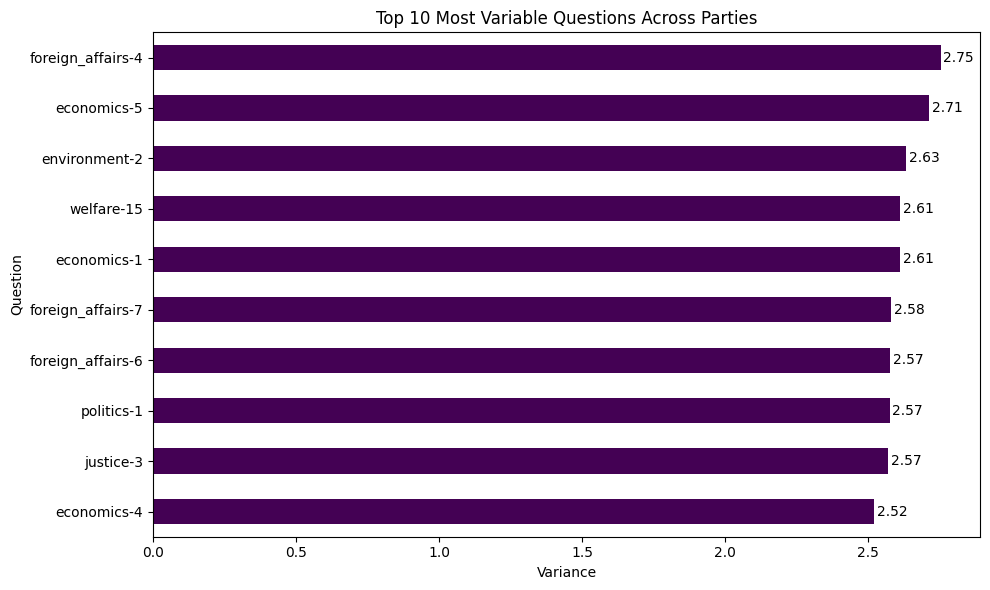

In [80]:
# Grouping by question and calculating variance across all parties
interparty_variation = alldata[answers.columns].var()

# Sorting the variance across all questions
interparty_variation_sorted = interparty_variation.sort_values(ascending=False)

# Check the result: Sorted variance for each question across all parties
print("Interparty Variance per Question:\n", interparty_variation_sorted)

# Plotting: Creating a horizontal bar plot for the top 10 most variable questions
# Top 10 most variable questions
top_10_interparty_variance = interparty_variation_sorted.head(10)

# Plotting
plt.figure(figsize=(10, 6))
top_10_interparty_variance.plot(kind='barh', colormap='viridis')
plt.gca().invert_yaxis() 
# Adding labels and title
plt.xlabel('Variance')
plt.ylabel('Question')
plt.title('Top 10 Most Variable Questions Across Parties')
for i, v in enumerate(top_10_interparty_variance):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()


## Most Crucial Questions by Political Party

                                             foreign_affairs-4  economics-5  \
parti                                                                         
Alternativet                                         -1.850746    -0.910448   
Danmarksdemokraterne                                  1.837838    -1.918919   
Dansk Folkeparti                                      1.836735    -1.510204   
Det Konservative Folkeparti                           1.010204     1.744898   
Enhedslisten                                         -1.959459    -1.864865   
Frie Grønne, Danmarks Nye Venstrefløjsparti          -2.000000    -1.846154   
Kristendemokraterne                                  -1.857143     1.261905   
Liberal Alliance                                      0.742857     1.928571   
Løsgænger                                            -0.666667    -1.000000   
Moderaterne                                          -0.904762     1.428571   
Nye Borgerlige                                      

<Figure size 1200x800 with 0 Axes>

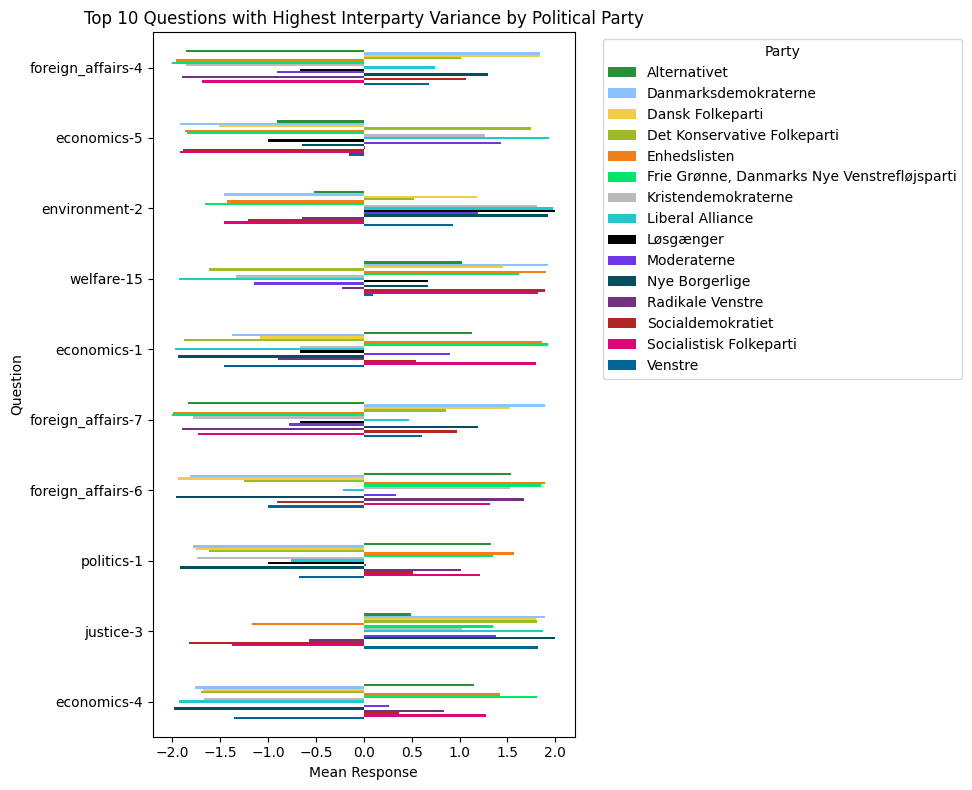

In [81]:
top_10_questions = top_10_interparty_variance.index
mean_responses = alldata.groupby('parti')[top_10_questions].mean()
print(mean_responses)

danskcolor = {"Socialdemokratiet": '#b32722',
"Radikale Venstre" : '#713280',
"Det Konservative Folkeparti": '#9eba27',
"Nye Borgerlige": '#054f5c',
"Socialistisk Folkeparti" : '#dd0878',
"Liberal Alliance": '#21c6cf',
"Kristendemokraterne": '#bababa',
"Moderaterne": '#6c39e5',
"Dansk Folkeparti": '#f3cd41',
"Frie Grønne, Danmarks Nye Venstrefløjsparti": '#00e66a',
"Venstre": '#006697',
"Danmarksdemokraterne": '#8ac3ff',
"Enhedslisten": '#ed8019',
"Alternativet": '#2a8f39',
"Løsgænger": '#000000'}

top_10_questions = interparty_variation_sorted.head(10)
top_10_variance_data = alldata.groupby('parti')[top_10_questions.index].mean()
colors = [danskcolor[party] for party in top_10_variance_data.index]

plt.figure(figsize=(12, 8))
top_10_variance_data.T.plot(kind='barh', figsize=(10, 8), color=colors)
plt.gca().invert_yaxis()
plt.xlabel('Mean Response')
plt.ylabel('Question')
plt.title('Top 10 Questions with Highest Interparty Variance by Political Party')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

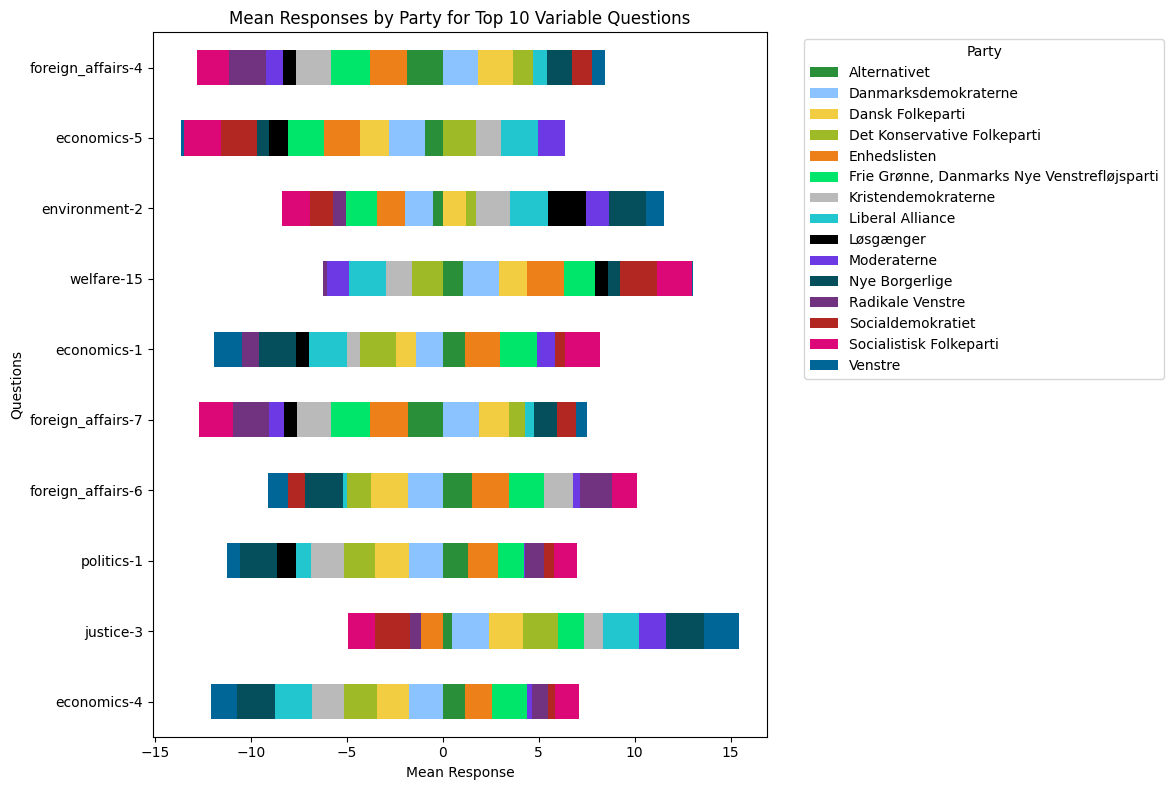

In [82]:
mean_responses.T.plot(kind='barh', figsize=(12, 8), color=colors, stacked=True)
plt.title('Mean Responses by Party for Top 10 Variable Questions')
plt.xlabel('Mean Response')
plt.ylabel('Questions')
plt.gca().invert_yaxis()
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Cluster Analysis
### PCA


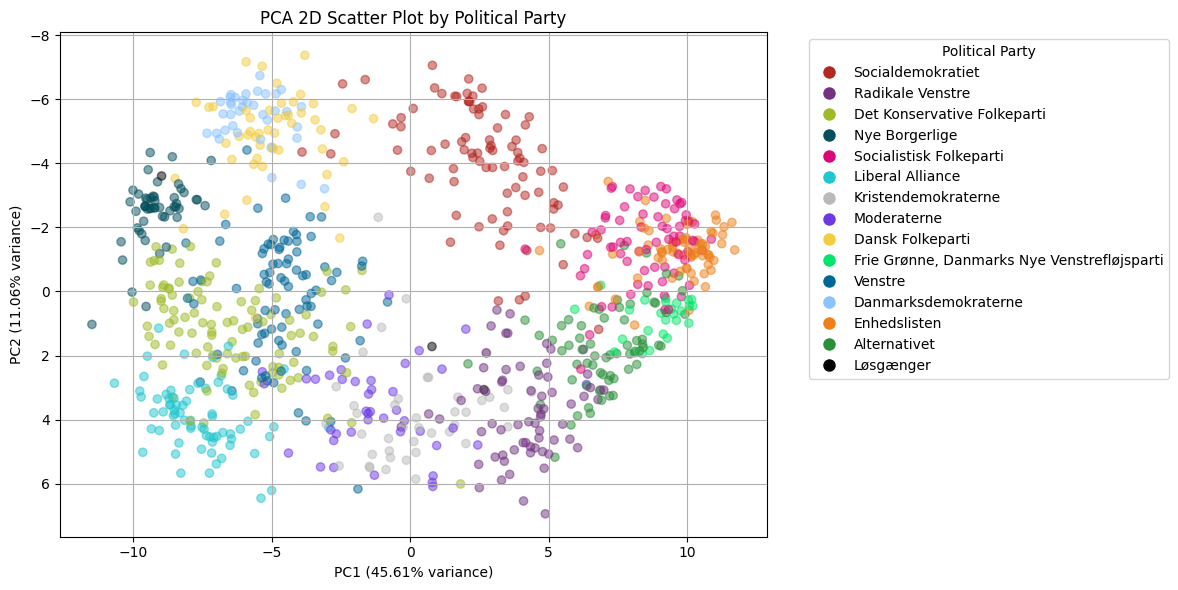

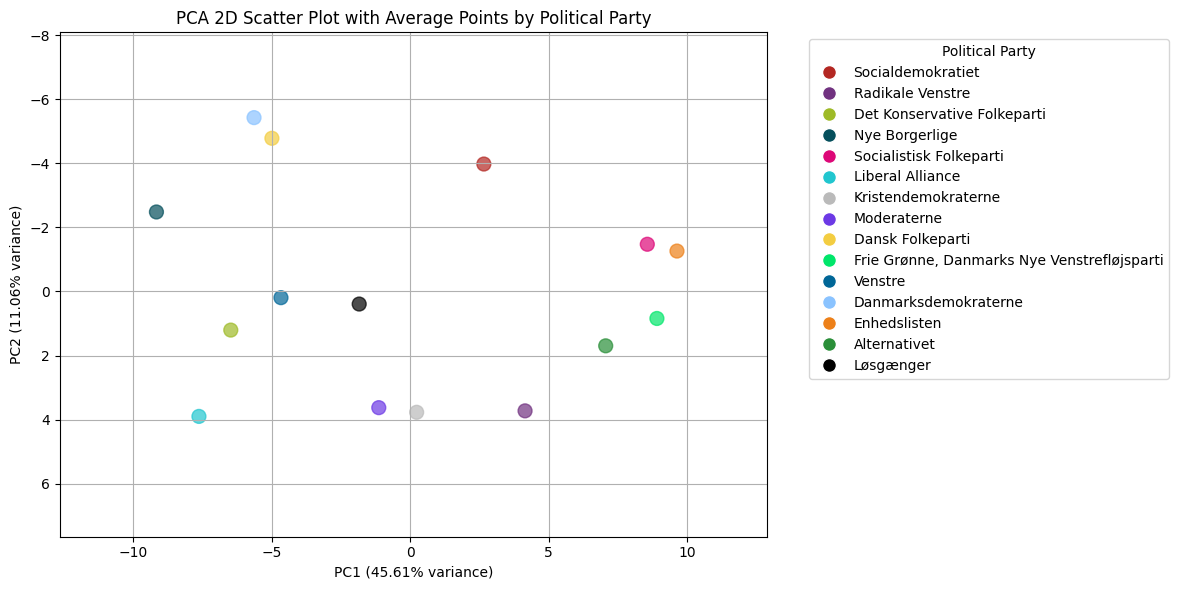

In [83]:
# PCA
party_positions = q_and_a.groupby(segments['parti']).median()  # Group by party and get the median
pca = PCA(n_components=2)
q_and_a_pca = pca.fit_transform(q_and_a)  # Perform PCA on the q_and_a DataFrame

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Convert PCA result back to DataFrame
pca_columns = ['PC1', 'PC2']
q_and_a_pca_df = pd.DataFrame(q_and_a_pca, columns=pca_columns)
q_and_a_pca_df['party_column'] = segments['parti'].values
q_and_a_pca_df['party_color'] = q_and_a_pca_df['party_column'].map(danskcolor)

# Get the axis limits for consistency across both plots
x_min, x_max = q_and_a_pca[:, 0].min(), q_and_a_pca[:, 0].max()
y_min, y_max = q_and_a_pca[:, 1].min(), q_and_a_pca[:, 1].max()

# Ensure some padding on the axis limits for better visualization
padding = 0.05
plt_x_min, plt_x_max = x_min - (x_max - x_min) * padding, x_max + (x_max - x_min) * padding
plt_y_min, plt_y_max = y_min - (y_max - y_min) * padding, y_max + (y_max - y_min) * padding

# Plot 1: PCA 2D Scatter Plot by Political Party
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    q_and_a_pca[:, 0], q_and_a_pca[:, 1], 
    c=q_and_a_pca_df['party_color'], alpha=0.5
)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=party) 
           for party, color in danskcolor.items()]
plt.legend(handles=handles, title='Political Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]*100:.2f}% variance)')
plt.title('PCA 2D Scatter Plot by Political Party')
plt.grid(True)

# Set the same axis limits for both plots
plt.xlim(plt_x_min, plt_x_max)
plt.ylim(plt_y_min, plt_y_max)

# Invert the PC2 axis
plt.gca().invert_yaxis()

# Adjust the layout to make room for the legend
plt.tight_layout()
plt.show()

# Plot 2: PCA 2D Scatter Plot with Average Points by Political Party
avg_points = q_and_a_pca_df.groupby('party_column')[['PC1', 'PC2']].mean()  # Average by political party

# Plotting the average points only
plt.figure(figsize=(12, 6))

# Scatter plot of average points for each political party
plt.scatter(avg_points['PC1'], avg_points['PC2'], c=avg_points.index.map(danskcolor), alpha=0.7, s=100)

# Add a legend for the political parties using the color dictionary
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=party) 
           for party, color in danskcolor.items()]

# Place the legend outside the plot (on the right)
plt.legend(handles=handles, title='Political Party', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add explained variance ratio to axis labels
plt.xlabel(f'PC1 ({explained_variance_ratio[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]*100:.2f}% variance)')
plt.title('PCA 2D Scatter Plot with Average Points by Political Party')
plt.grid(True)

# Set the same axis limits for both plots
plt.xlim(plt_x_min, plt_x_max)
plt.ylim(plt_y_min, plt_y_max)

# Invert the PC2 axis
plt.gca().invert_yaxis()

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()


### KMeans

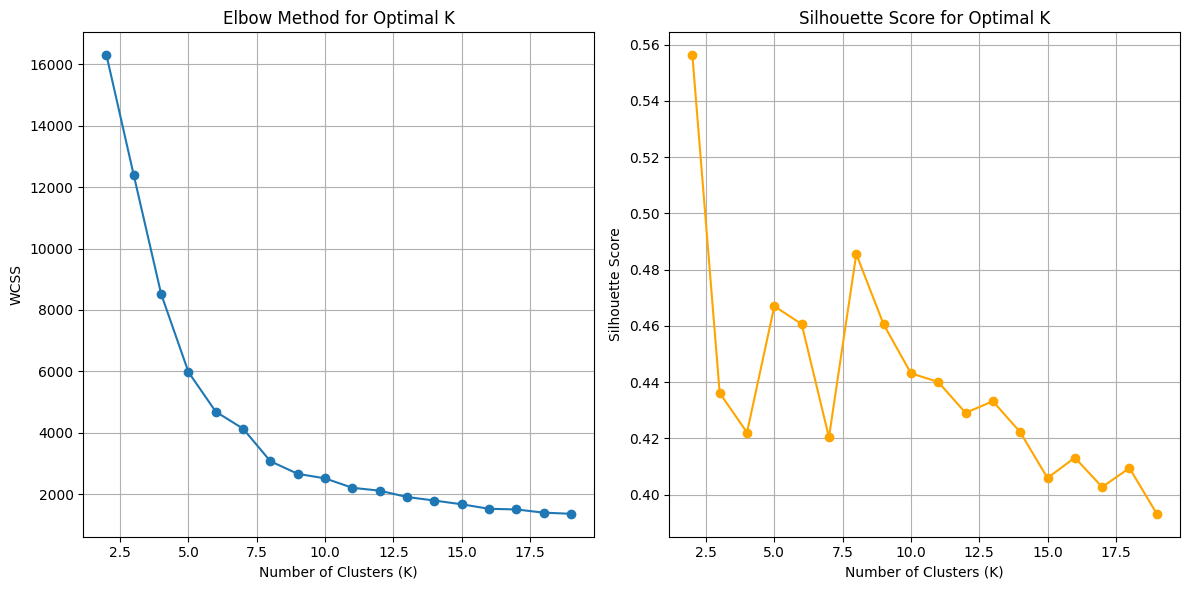

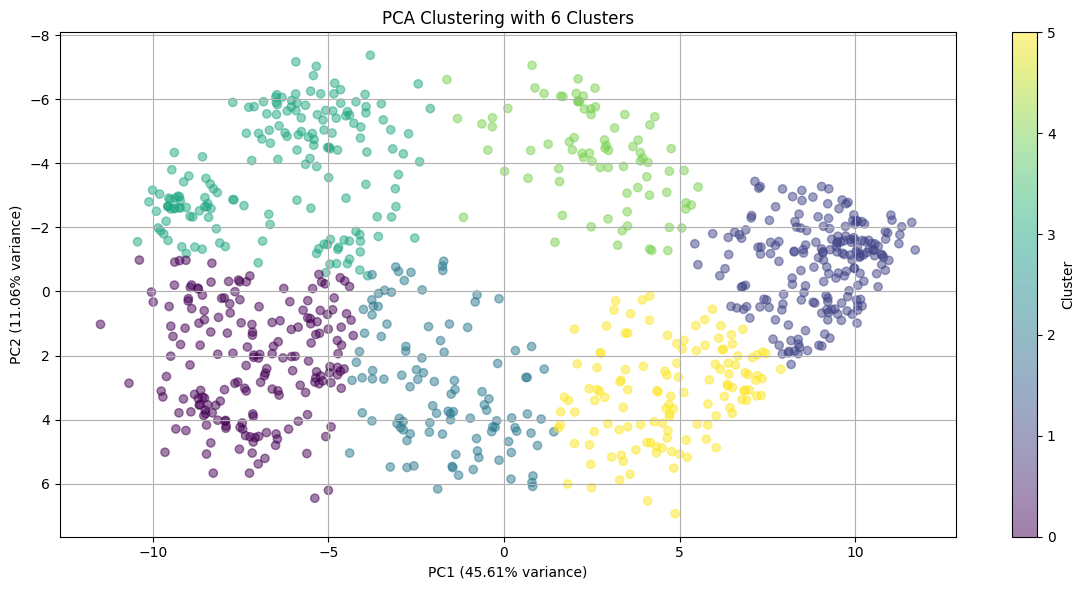

In [84]:
# KMeans clustering
# Elbow Method to find optimal number of clusters
wcss = []
silhouette_scores = []
k_range = range(2, 20)  

for k in k_range:
    # Fit the KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(q_and_a_pca)

    # Compute the within-cluster sum of squares (WCSS) for Elbow Method
    wcss.append(kmeans.inertia_)

    # Compute the silhouette score for the silhouette method
    silhouette_avg = silhouette_score(q_and_a_pca, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the Elbow Method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)

# Plot the Silhouette Score for each K
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Optimal number of clusters is chosen in terms of the silhouette score as well as the elbow method.
optimal_k = 6

# Fit KMeans with the selected optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
q_and_a_pca_df['Cluster'] = kmeans_final.fit_predict(q_and_a_pca)

# Plot the final clustering result
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    q_and_a_pca[:, 0], q_and_a_pca[:, 1], 
    c=q_and_a_pca_df['Cluster'], cmap='viridis', alpha=0.5
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]*100:.2f}% variance)')
plt.title(f'PCA Clustering with {optimal_k} Clusters')
plt.grid(True)

# Invert the PC2 axis
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


### Hierarchical Clustering

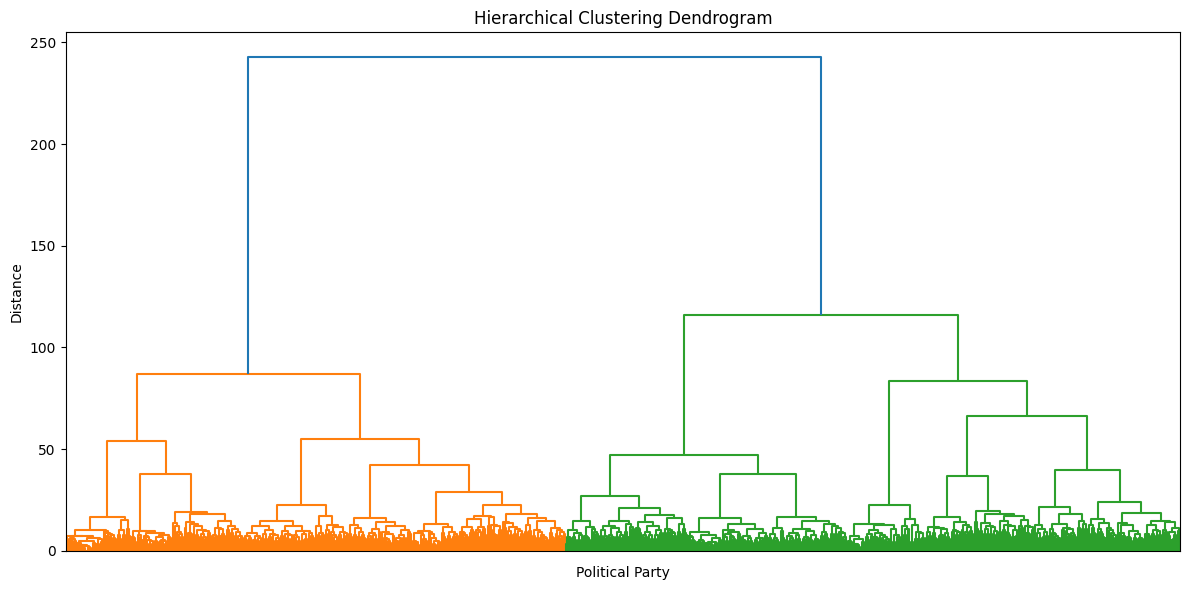

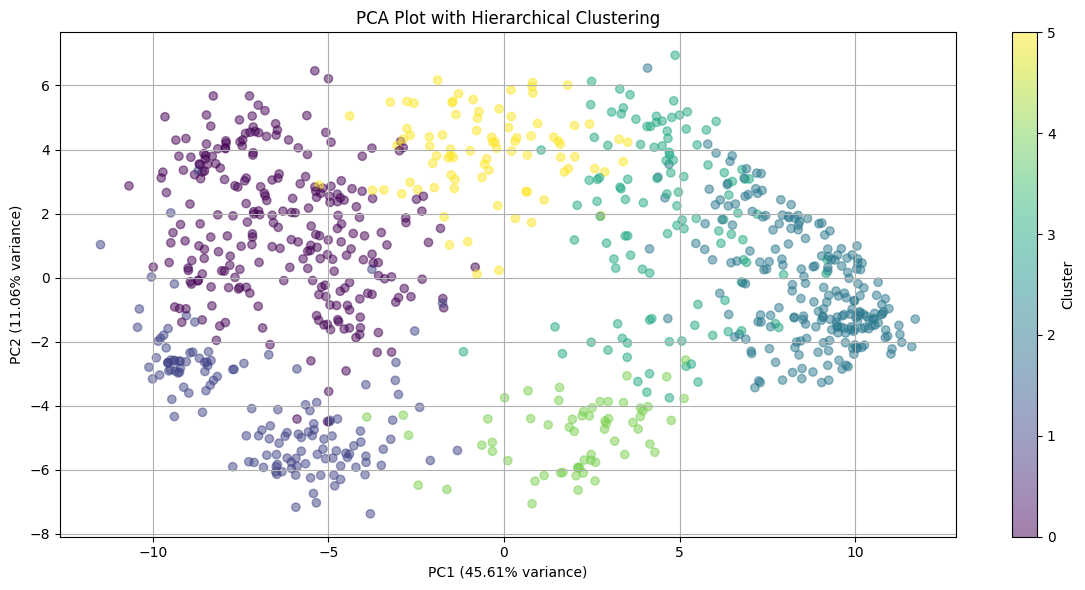

In [85]:
# Perform hierarchical clustering using linkage method
Z = linkage(q_and_a, method='ward')

# Plot the dendrogram without labels
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=[None] * len(segments), leaf_rotation=90)  # Removed party labels
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Political Party')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Fit the AgglomerativeClustering model with the desired number of clusters
hierarchical_model = AgglomerativeClustering(n_clusters=6, linkage='ward')
q_and_a_pca_df['Hierarchical Cluster'] = hierarchical_model.fit_predict(q_and_a)

# Plot the clustering result in 2D (PCA plot)
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    q_and_a_pca[:, 0], q_and_a_pca[:, 1], 
    c=q_and_a_pca_df['Hierarchical Cluster'], cmap='viridis', alpha=0.5
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]*100:.2f}% variance)')
plt.title('PCA Plot with Hierarchical Clustering')
plt.grid(True)
plt.tight_layout()
plt.show()

### t-SNE and DBSCAN

C:\Users\Ginta Bilinska\AppData\Local\Temp\ipykernel_35940\3276190149.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(q_and_a_tsne_df['tSNE1'], q_and_a_tsne_df['tSNE2'],


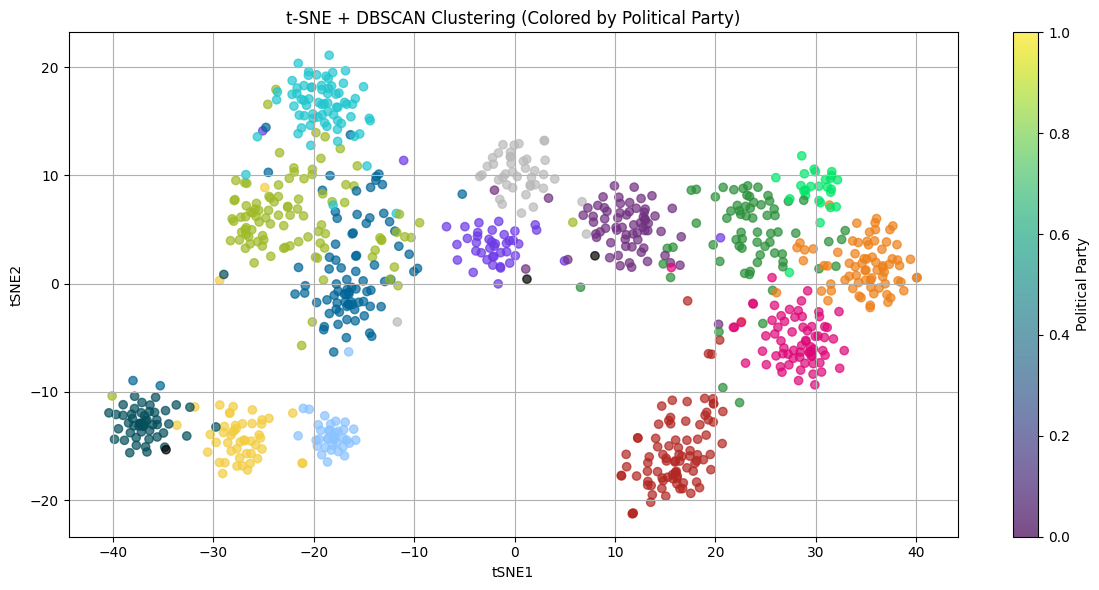

In [93]:
# For the future - add graphs also to visualize the variance with t-SNE 

# Apply t-SNE for dimensionality reduction (you can adjust n_components as needed)
tsne = TSNE(n_components=2, random_state=42)
q_and_a_tsne = tsne.fit_transform(q_and_a)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)  # You may need to adjust eps and min_samples based on your data
q_and_a_tsne_df = pd.DataFrame(q_and_a_tsne, columns=['tSNE1', 'tSNE2'])
q_and_a_tsne_df['DBSCAN_Labels'] = dbscan.fit_predict(q_and_a_tsne)

# Map political party affiliation to dansk_colors for coloring
q_and_a_tsne_df['Party'] = segments['parti'].values
q_and_a_tsne_df['Party_Color'] = q_and_a_tsne_df['Party'].map(danskcolor)

# Visualize the t-SNE and DBSCAN results with party colors
plt.figure(figsize=(12, 6))

# Scatter plot of t-SNE results colored by political party
scatter = plt.scatter(q_and_a_tsne_df['tSNE1'], q_and_a_tsne_df['tSNE2'], 
                      c=q_and_a_tsne_df['Party_Color'], cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='Political Party')
plt.title('t-SNE + DBSCAN Clustering (Colored by Political Party)')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')

plt.grid(True)

plt.tight_layout()
plt.show()

Based on the graph, it seems like some of the clusters could form bigger clusters, ending up in 5 or 6 clusters AKA political parties.

## Overview Elected Candidates

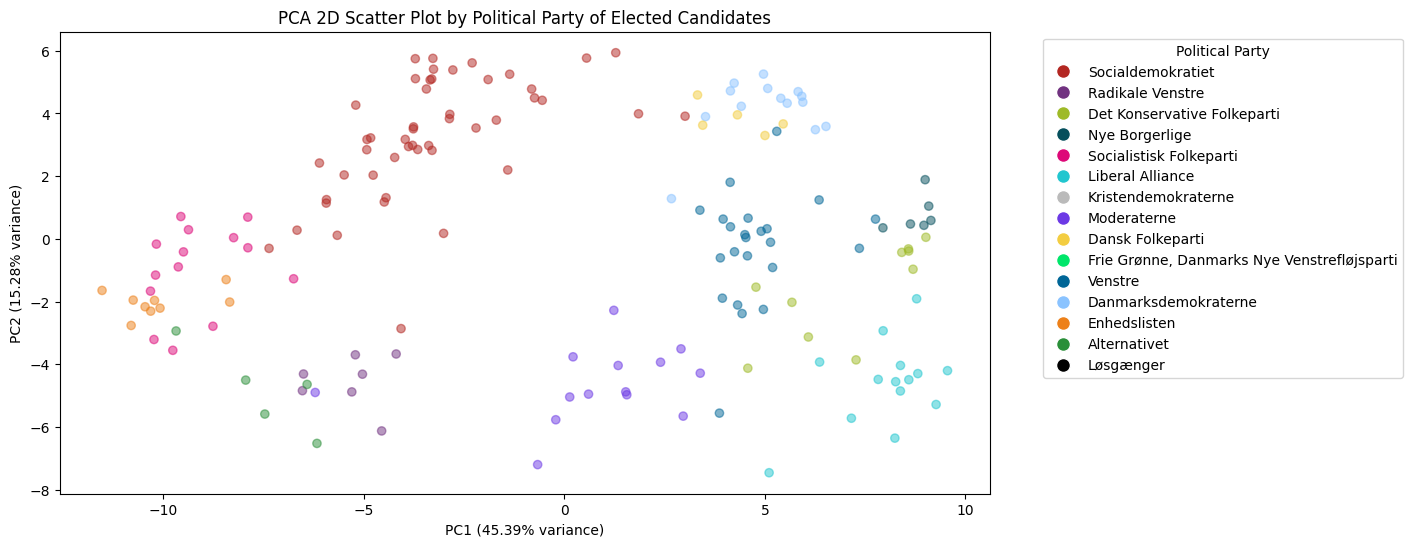

Most disagreeing candidates from Socialistisk Folkeparti:
Candidate 1: Sofie Lippert
Candidate 2: Jacob Mark

Most disagreeing candidates from Alternativet:
Candidate 1: Torsten Gejl
Candidate 2: Christina Sade Olumeko

Most disagreeing candidates from Enhedslisten:
Candidate 1: Peder Hvelplund
Candidate 2: Søren Søndergaard

Most disagreeing candidates from Danmarksdemokraterne:
Candidate 1: Inger Støjberg
Candidate 2: Kenneth Fredslund Petersen

Most disagreeing candidates from Venstre:
Candidate 1: Michael Aastrup Jensen
Candidate 2: Jan E. Jørgensen

Most disagreeing candidates from Dansk Folkeparti:
Candidate 1: Nick Zimmermann
Candidate 2: Pia Kjærsgaard

Most disagreeing candidates from Moderaterne:
Candidate 1: Jon Læssøe Stephensen
Candidate 2: Jeppe Søe

Most disagreeing candidates from Liberal Alliance:
Candidate 1: Alexander Ryle
Candidate 2: Henrik Dahl

Most disagreeing candidates from Nye Borgerlige:
Candidate 1: Lars Boje Mathiesen
Candidate 2: Mikkel Bjørn

Most disagr

In [ ]:
# Future add a benchmark for the difference to only show candidates that are significantly dissagreeing and maybe add if a cadidante is significant different from the party
# Rename columns and separate the questions and answers
electeddata = electeddata.rename(columns=col_index)
electeddata_q = electeddata[electeddata.columns[electeddata.columns.astype(str).isin(questions.index.astype(str))]]
Categorical_elec = electeddata.drop(answers.columns, axis=1)

# Apply PCA 
pca = PCA(n_components=2)
electeddata_pca = pca.fit_transform(electeddata_q)  
explained_variance_ratio = pca.explained_variance_ratio_
pca_columns = ['PC1', 'PC2']
electeddata_pca_df = pd.DataFrame(electeddata_pca, columns=pca_columns)

# Adding the categorical info that we are interesested in
electeddata_pca_df['party_column'] = Categorical_elec['parti'].values
electeddata_pca_df['party_color'] = electeddata_pca_df['party_column'].map(danskcolor)
electeddata_pca_df['name'] = Categorical_elec['navn'].values  

# Plot by Political Party
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    electeddata_pca[:, 0], electeddata_pca[:, 1], 
    c=electeddata_pca_df['party_color'], alpha=0.5
)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=party) 
           for party, color in danskcolor.items()]
plt.legend(handles=handles, title='Political Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]*100:.2f}% variance)')
plt.title('PCA 2D Scatter Plot by Political Party of Elected Candidates')
plt.show()

# Analyze disagreement between candidates within the same party
party_disagreements = {}
for party in electeddata_pca_df['party_column'].unique():
    party_df = electeddata_pca_df[electeddata_pca_df['party_column'] == party]
    distances = euclidean_distances(party_df[['PC1', 'PC2']])
    
    # Find pairs of candidates with the highest distance (disagreement)
    max_disagreement_idx = distances.argmax()
    i, j = divmod(max_disagreement_idx, distances.shape[1])
    most_disagreeing_pair = (party_df.iloc[i], party_df.iloc[j])
    
    print(f"Most disagreeing candidates from {party}:")
    print(f"Candidate 1: {most_disagreeing_pair[0]['name']}")
    print(f"Candidate 2: {most_disagreeing_pair[1]['name']}\n")

# Analyze disagreement between between all candidates
electeddata_pca_combined = electeddata_pca_df[['PC1', 'PC2', 'name', 'party_column']]
all_distances = euclidean_distances(electeddata_pca_combined[['PC1', 'PC2']])

# Find the maximum distance
max_disagreement_idx = all_distances.argmax()
i, j = divmod(max_disagreement_idx, all_distances.shape[1])
most_disagreeing_pair_all = (electeddata_pca_combined.iloc[i], electeddata_pca_combined.iloc[j])

print(f"Most disagreeing candidates across all parties:")
print(f"Candidate 1: {most_disagreeing_pair_all[0]['name']} from {most_disagreeing_pair_all[0]['party_column']}")
print(f"Candidate 2: {most_disagreeing_pair_all[1]['name']} from {most_disagreeing_pair_all[1]['party_column']}\n")

# Analyze disagreement between all political parties
party_distances = {}
for party1 in electeddata_pca_df['party_column'].unique():
    for party2 in electeddata_pca_df['party_column'].unique():
        if party1 != party2:
            party1_candidates = electeddata_pca_df[electeddata_pca_df['party_column'] == party1]
            party2_candidates = electeddata_pca_df[electeddata_pca_df['party_column'] == party2]
            
            # Calculate pairwise distances between candidates from different parties
            distances = euclidean_distances(party1_candidates[['PC1', 'PC2']], party2_candidates[['PC1', 'PC2']])
            
            # Compute the average distance between the two parties
            avg_distance = distances.mean()
            party_distances[(party1, party2)] = avg_distance

# Find the pair of parties with the highest average distance
most_different_parties = max(party_distances, key=party_distances.get)
print(f"The two most different political parties are {most_different_parties[0]} and {most_different_parties[1]} with an average distance of {party_distances[most_different_parties]:.2f}")